Interpretability for MLP Model

Taken from here: https://captum.ai/tutorials/House_Prices_Regression_Interpret

In [1]:
import numpy as np
import pandas as pd
import os
from os import path
import sys
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
import lightning as L

# Captum imports for model interpretability
from captum.attr import LayerConductance, LayerActivation, LayerIntegratedGradients
from captum.attr import IntegratedGradients, DeepLift, GradientShap, NoiseTunnel, FeatureAblation

# Grab MLP model and data class from the base training script
# Dynamically construct the path based on the user's home directory
base_path = os.path.expanduser('~/clotsimnet')

# Add the utils directory to sys.path
sys.path.append(os.path.join(base_path, 'ml', 'data_modules'))
# Dynamically construct the path based on the user's home directory
sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__name__), '..')))
from load_data import MLPClotDataset, MLPClotDataseto1
from model_classes import MLP

n_steps = 25

/home/josh/anaconda3/envs/clotsimnet/lib/python3.11/site-packages/onnxscript/converter.py:823: FutureWarning: 'onnxscript.values.Op.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()
/home/josh/anaconda3/envs/clotsimnet/lib/python3.11/site-packages/onnxscript/converter.py:823: FutureWarning: 'onnxscript.values.OnnxFunction.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()


# Full Base MLP

Load dataset

In [3]:
csv_path = '/home/josh/clotsimnet/data/mlp_data_test.csv'
batch_size = 32
num_workers = 18

# Load dataset
data_module = MLPClotDataset(csv_path=csv_path, batch_size=batch_size, num_workers=num_workers)
data_module.setup()

data = pd.read_csv(csv_path)

data = data.dropna(axis=1) # Remove NaN values
# Get feature columns
start_idx = data.columns.get_loc('img_mean_intensity')
feature_cols = data.columns[start_idx:]

input_data = data[feature_cols].values.astype('float32')
scaler = StandardScaler()
input_data = scaler.fit_transform(input_data)

labels = data['k'].values.astype('float32').reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(input_data, labels, test_size=0.3, random_state=0)

X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).view(-1, 1).float()

X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).view(-1, 1).float()

datasets = torch.utils.data.TensorDataset(X_train, y_train)
train_iter = torch.utils.data.DataLoader(datasets, batch_size=10, shuffle=True)

# Extract names of the features for plotting later
feature_names = data[feature_cols].columns.tolist()

Create MLP with default hyperparameters

In [4]:
# Base MLP hyperparameters

model = MLP.MLP(
    input_size=data_module.X.shape[1]
)

Load the trained base MLP PyTorch model state_dict():

In [7]:
from safetensors import safe_open
def load_safetensors(model_obj, model_path):
    if path.isfile(model_path):
        # Load model
        print('Loading pre-trained model from: {}'.format(model_path))
        tensors = {}
        with safe_open(model_path, framework="pt", device=0) as f:
            for k in f.keys():
                tensors[k] = f.get_tensor(k)
    else:
        print('Model state_dict not found')
        pass

In [6]:
SAFETENSORS_MODEL_PATH = '/home/josh/ClotSimNet-Models/tuned/mlp_full/mlp_full_tuned.safetensors'
load_safetensors(model_obj=model, model_path=SAFETENSORS_MODEL_PATH)

Loading pre-trained model from: /home/josh/ClotSimNet-Models/tuned/mlp_full/mlp_full_tuned.safetensors


Set model into evaluation mode:

In [7]:
model.eval()

MLP(
  (model): Sequential(
    (0): Linear(in_features=260, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
    (5): Linear(in_features=128, out_features=1, bias=True)
  )
  (train_metrics): MetricCollection(
    (MAE): MeanAbsoluteError()
    (MSE): MeanSquaredError()
    (RMSE): MeanSquaredError()
    (r_squared): R2Score(),
    prefix=train_
  )
  (valid_metrics): MetricCollection(
    (MAE): MeanAbsoluteError()
    (MSE): MeanSquaredError()
    (RMSE): MeanSquaredError()
    (r_squared): R2Score(),
    prefix=valid_
  )
  (test_metrics): MetricCollection(
    (MAE): MeanAbsoluteError()
    (MSE): MeanSquaredError()
    (RMSE): MeanSquaredError()
    (r_squared): R2Score(),
    prefix=test_
  )
)

Run different attribution algorithms:

In [13]:
dl = DeepLift(model)
gs = GradientShap(model)
fa = FeatureAblation(model)

dl_attr_test = dl.attribute(X_test)
gs_attr_test = gs.attribute(X_test, X_train)
fa_attr_test = fa.attribute(X_test)

Visualize attribution scores:

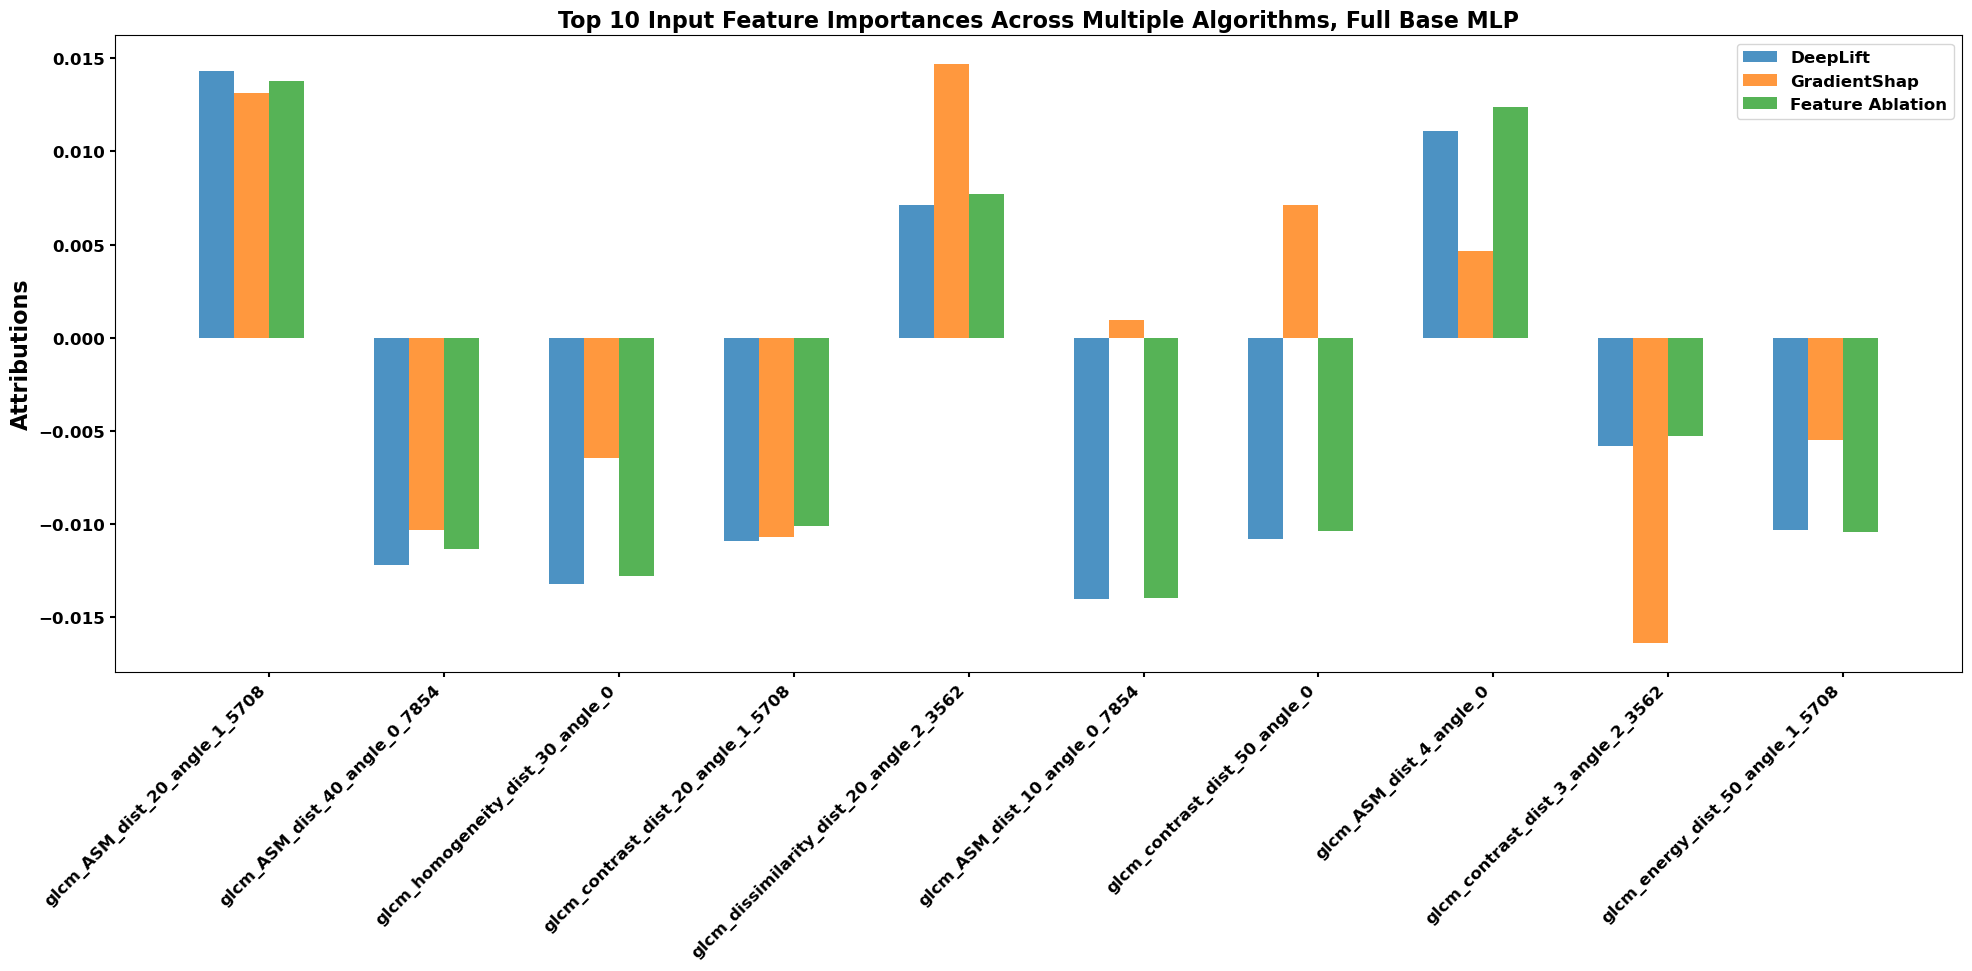

In [ ]:
# Top N features

# prepare attributions for visualization

x_axis_data = np.arange(X_test.shape[1])
x_axis_data_labels = list(map(lambda idx: feature_names[idx], x_axis_data))


dl_attr_test_sum = dl_attr_test.detach().numpy().sum(0)
dl_attr_test_norm_sum = dl_attr_test_sum / np.linalg.norm(dl_attr_test_sum, ord=1)

gs_attr_test_sum = gs_attr_test.detach().numpy().sum(0)
gs_attr_test_norm_sum = gs_attr_test_sum / np.linalg.norm(gs_attr_test_sum, ord=1)

fa_attr_test_sum = fa_attr_test.detach().numpy().sum(0)
fa_attr_test_norm_sum = fa_attr_test_sum / np.linalg.norm(fa_attr_test_sum, ord=1)


# lin_weight = model.model[0].weight[0].detach().numpy()
# y_axis_lin_weight = lin_weight / np.linalg.norm(lin_weight, ord=1)


# Step 1: Compute absolute values of attributions
dl_abs     = np.abs(dl_attr_test_norm_sum)
gs_abs     = np.abs(gs_attr_test_norm_sum)
fa_abs     = np.abs(fa_attr_test_norm_sum)

# Step 2: Combine the importance values for an overall ranking.
# Here, we take an average (you could also use sum or another aggregation).
combined_importance = (dl_abs + gs_abs + fa_abs) / 3.0

# Step 3: Get indices for the top N features based on the combined importance.
top_n = 10  # adjust this number to change the number of top features
sorted_indices = np.argsort(-combined_importance)  # negative sign to sort in descending order
top_indices = sorted_indices[:top_n]

# Step 4: Subset the attribution arrays and feature names to only include top features.
top_dl     = dl_attr_test_norm_sum[top_indices]
top_gs     = gs_attr_test_norm_sum[top_indices]
top_fa     = fa_attr_test_norm_sum[top_indices]
top_feature_names = [feature_names[i] for i in top_indices]

# Step 5: Create x-axis data for plotting.
x_axis_data = np.arange(top_n)
width = 0.2  # defines the width of each bar

# Step 6: Plotting the data using a grouped bar chart.
plt.figure(figsize=(20, 10))
plt.bar(x_axis_data + width,    top_dl,    width, label='DeepLift',         alpha=0.8)
plt.bar(x_axis_data + 2*width,    top_gs,    width, label='GradientShap',     alpha=0.8)
plt.bar(x_axis_data + 3*width,    top_fa,    width, label='Feature Ablation', alpha=0.8)

# Adjust x-axis ticks & labels
plt.xticks(x_axis_data + 2.5*width, top_feature_names, rotation=45, ha='right', fontweight='bold')
plt.ylabel('Attributions', fontweight='bold')
plt.title('Top {} Input Feature Importances Across Multiple Algorithms, Full Base MLP'.format(top_n), fontweight='bold')
plt.legend(loc='best', prop={'weight':'bold'})

# Set bold font for ticks
plt.tick_params(axis='both', which='major', labelsize=12, labelcolor='black', width=1.5)
for label in plt.gca().get_xticklabels() + plt.gca().get_yticklabels():
    label.set_fontweight('bold')
plt.tight_layout()
# plt.show()
plt.savefig('full_base_mlp_attribs.svg')

# Full Tuned MLP

In [20]:
import json

# Path to hyperparameter JSON file
hyperparams_path = '/home/josh/ClotSimNet-Models/hyperparameters/best_params_mlp.json'

with open(hyperparams_path, 'r') as f:
    hyperparams = json.load(f)
    
hyperparameters = hyperparams['hyperparameters']

In [21]:
csv_path = '/home/josh/clotsimnet/data/mlp_data_test.csv'
batch_size = hyperparameters['batch_size']
num_workers = 18

# Load dataset
data_module = MLPClotDataset(csv_path=csv_path, batch_size=batch_size, num_workers=num_workers)
data_module.setup()

data = pd.read_csv(csv_path)

data = data.dropna(axis=1) # Remove NaN values
# Get feature columns
start_idx = data.columns.get_loc('img_mean_intensity')
feature_cols = data.columns[start_idx:]

input_data = data[feature_cols].values.astype('float32')
scaler = StandardScaler()
input_data = scaler.fit_transform(input_data)

labels = data['k'].values.astype('float32').reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(input_data, labels, test_size=0.3, random_state=0)

X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).view(-1, 1).float()

X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).view(-1, 1).float()

datasets = torch.utils.data.TensorDataset(X_train, y_train)
train_iter = torch.utils.data.DataLoader(datasets, batch_size=10, shuffle=True)

# Extract names of the features for plotting later
feature_names = data[feature_cols].columns.tolist()

In [ ]:
model = MLP.MLP(
        input_size=data_module.X.shape[1],
        hidden_size=hyperparameters['hidden_size'],
        num_layers=hyperparameters['num_layers'],
        learning_rate=hyperparameters['lr'],
        weight_decay=hyperparameters['weight_decay'],
        scheduler_factor=hyperparameters['scheduler_factor'],
        scheduler_patience=hyperparameters['scheduler_patience'],
        scheduler_threshold=hyperparameters['scheduler_threshold']
    )

SAFETENSORS_MODEL_PATH = '/home/josh/ClotSimNet-Models/tuned/mlp_full/mlp_full_tuned.safetensors'
load_safetensors(model_obj=model, model_path=SAFETENSORS_MODEL_PATH)

# Set model into evaluation mode
model.eval()

Load the model's Safetensors weights:

In [23]:
SAFETENSORS_MODEL_PATH = '/home/josh/ClotSimNet-Models/tuned/mlp_full/mlp_full_tuned.safetensors'
load_safetensors(model_obj=model, model_path=SAFETENSORS_MODEL_PATH)

Loading pre-trained model from: /home/josh/ClotSimNet-Models/tuned/mlp_full/mlp_full_tuned.safetensors


Set model into evaluation mode:

In [24]:
model.eval()

MLP(
  (model): Sequential(
    (0): Linear(in_features=260, out_features=1480, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1480, out_features=1, bias=True)
  )
  (train_metrics): MetricCollection(
    (MAE): MeanAbsoluteError()
    (MSE): MeanSquaredError()
    (RMSE): MeanSquaredError()
    (r_squared): R2Score(),
    prefix=train_
  )
  (valid_metrics): MetricCollection(
    (MAE): MeanAbsoluteError()
    (MSE): MeanSquaredError()
    (RMSE): MeanSquaredError()
    (r_squared): R2Score(),
    prefix=valid_
  )
  (test_metrics): MetricCollection(
    (MAE): MeanAbsoluteError()
    (MSE): MeanSquaredError()
    (RMSE): MeanSquaredError()
    (r_squared): R2Score(),
    prefix=test_
  )
)

Run attribution algorithms:

In [25]:
dl = DeepLift(model)
gs = GradientShap(model)
fa = FeatureAblation(model)

dl_attr_test = dl.attribute(X_test)
gs_attr_test = gs.attribute(X_test, X_train)
fa_attr_test = fa.attribute(X_test)

/home/josh/anaconda3/envs/clotsimnet/lib/python3.11/site-packages/captum/attr/_core/deep_lift.py:294: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  gradient_mask = apply_gradient_requirements(inputs_tuple)
/home/josh/anaconda3/envs/clotsimnet/lib/python3.11/site-packages/captum/log/dummy_log.py:39: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  return func(*args, **kwargs)


Visualize top n attribution scores:

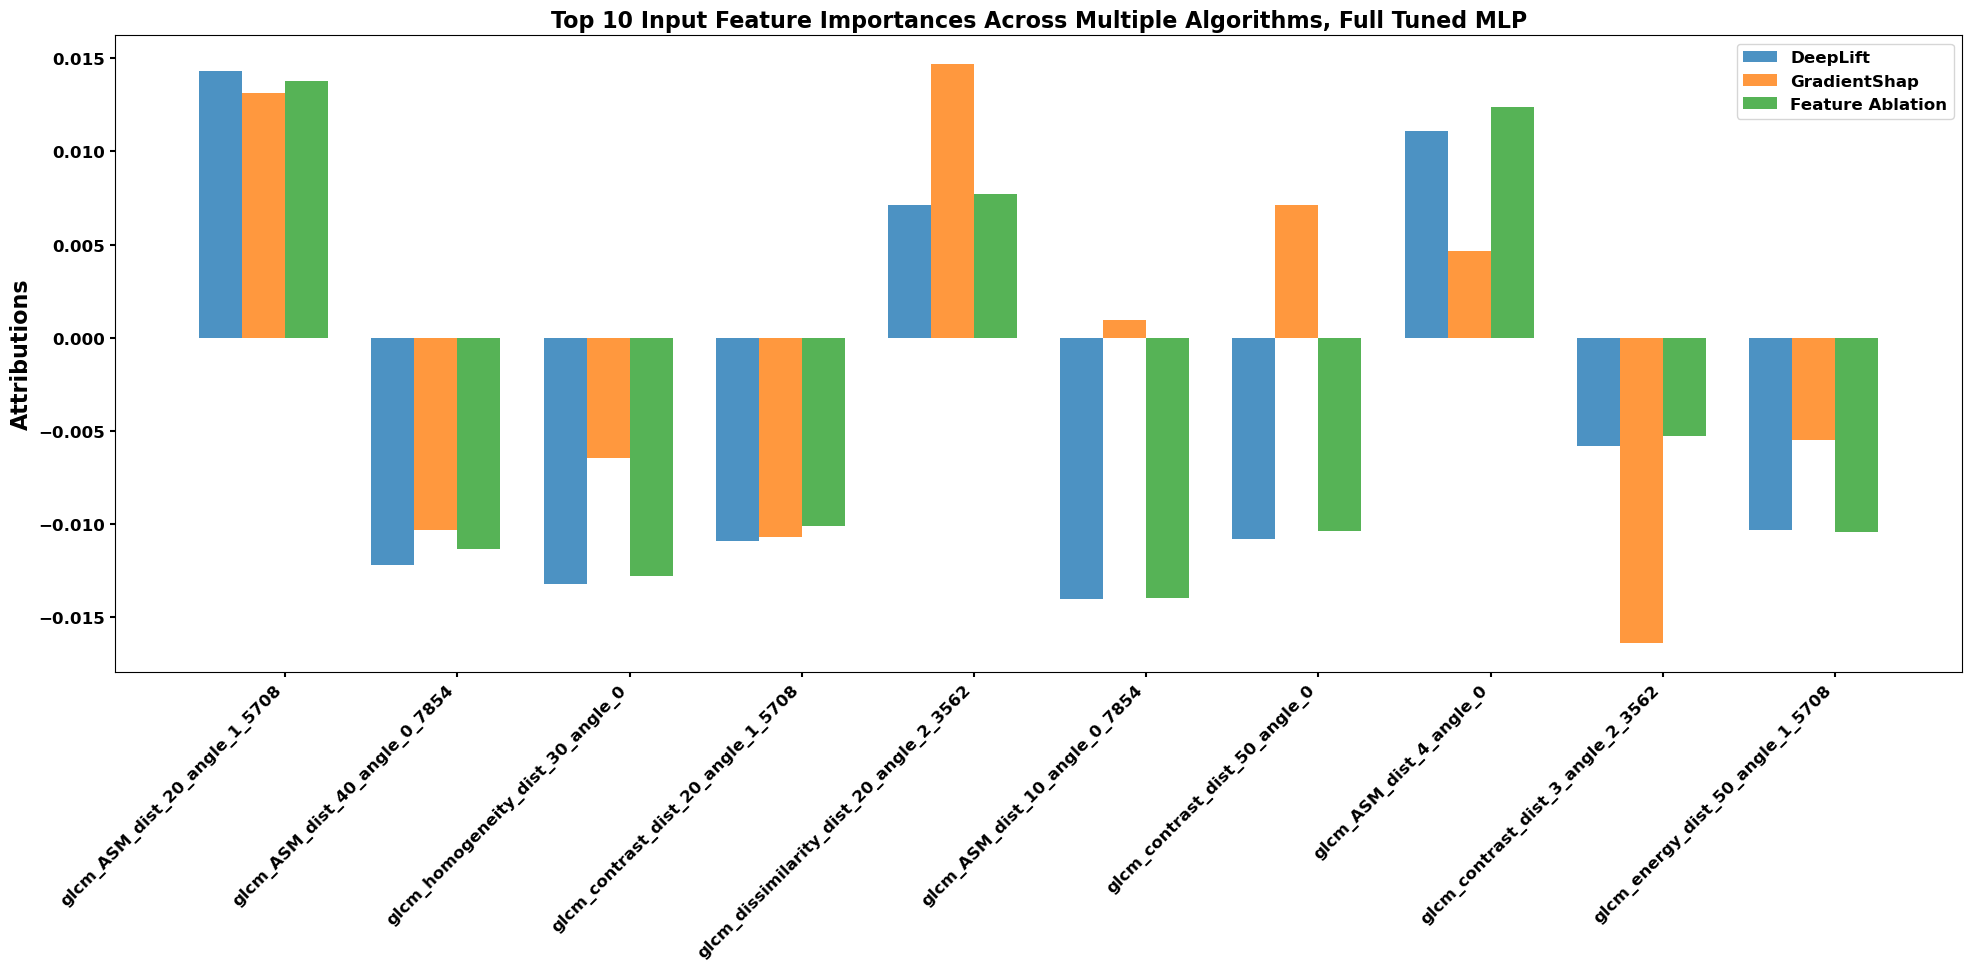

In [39]:
# Top N features

# prepare attributions for visualization

x_axis_data = np.arange(X_test.shape[1])
x_axis_data_labels = list(map(lambda idx: feature_names[idx], x_axis_data))


dl_attr_test_sum = dl_attr_test.detach().numpy().sum(0)
dl_attr_test_norm_sum = dl_attr_test_sum / np.linalg.norm(dl_attr_test_sum, ord=1)

gs_attr_test_sum = gs_attr_test.detach().numpy().sum(0)
gs_attr_test_norm_sum = gs_attr_test_sum / np.linalg.norm(gs_attr_test_sum, ord=1)

fa_attr_test_sum = fa_attr_test.detach().numpy().sum(0)
fa_attr_test_norm_sum = fa_attr_test_sum / np.linalg.norm(fa_attr_test_sum, ord=1)


lin_weight = model.model[0].weight[0].detach().numpy()
y_axis_lin_weight = lin_weight / np.linalg.norm(lin_weight, ord=1)


# Step 1: Compute absolute values of attributions
dl_abs     = np.abs(dl_attr_test_norm_sum)
gs_abs     = np.abs(gs_attr_test_norm_sum)
fa_abs     = np.abs(fa_attr_test_norm_sum)

# Step 2: Combine the importance values for an overall ranking.
# Here, we take an average (you could also use sum or another aggregation).
combined_importance = (dl_abs + gs_abs + fa_abs) / 3.0

# Step 3: Get indices for the top N features based on the combined importance.
top_n = 10  # adjust this number to change the number of top features
sorted_indices = np.argsort(-combined_importance)  # negative sign to sort in descending order
top_indices = sorted_indices[:top_n]

# Step 4: Subset the attribution arrays and feature names to only include top features.
top_dl     = dl_attr_test_norm_sum[top_indices]
top_gs     = gs_attr_test_norm_sum[top_indices]
top_fa     = fa_attr_test_norm_sum[top_indices]
top_feature_names = [feature_names[i] for i in top_indices]

# Step 5: Create x-axis data for plotting.
x_axis_data = np.arange(top_n)
width = 0.25  # defines the width of each bar

# Step 6: Plotting the data using a grouped bar chart.
plt.figure(figsize=(20, 10))
plt.bar(x_axis_data + width,    top_dl,    width, label='DeepLift',         alpha=0.8)
plt.bar(x_axis_data + 2*width,    top_gs,    width, label='GradientShap',     alpha=0.8)
plt.bar(x_axis_data + 3*width,    top_fa,    width, label='Feature Ablation', alpha=0.8)

# Adjust x-axis ticks & labels
plt.xticks(x_axis_data + 2.5*width, top_feature_names, rotation=45, ha='right', fontweight='bold')
plt.ylabel('Attributions', fontweight='bold')
plt.title('Top {} Input Feature Importances Across Multiple Algorithms, Full Tuned MLP'.format(top_n), fontweight='bold')
plt.legend(loc='best', prop={'weight':'bold'})

# Set bold font for ticks
plt.tick_params(axis='both', which='major', labelsize=12, labelcolor='black', width=1.5)
for label in plt.gca().get_xticklabels() + plt.gca().get_yticklabels():
    label.set_fontweight('bold')
plt.tight_layout()
# plt.show()
plt.savefig('full_tuned_mlp_attribs.svg')

# First-order Base MLP

In [6]:
csv_path = '/home/josh/clotsimnet/data/mlp_data_test.csv'
batch_size = 32
num_workers = 18

# Load dataset
data_module = MLPClotDataseto1(csv_path=csv_path, batch_size=batch_size, num_workers=num_workers)
data_module.setup()

df = pd.read_csv(csv_path)

df = df.dropna(axis=1) # Remove NaN values
# Get feature columns
start_idx = df.columns.get_loc('img_mean_intensity')
end_idx = df.columns.get_loc('img_kurtosis_intensity')

feature_cols = df.columns[start_idx:end_idx+1]

input_data = df[feature_cols].values.astype('float32')
scaler = StandardScaler()
input_data = scaler.fit_transform(input_data)

labels = df['k'].values.astype('float32').reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(input_data, labels, test_size=0.3, random_state=0)

X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).view(-1, 1).float()

X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).view(-1, 1).float()

datasets = torch.utils.data.TensorDataset(X_train, y_train)
train_iter = torch.utils.data.DataLoader(datasets, batch_size=10, shuffle=True)

# Extract names of the features for plotting later
feature_names = df[feature_cols].columns.tolist()

In [8]:
model = MLP.MLP(
        input_size=data_module.X.shape[1]
)

SAFETENSORS_MODEL_PATH = '/home/josh/ClotSimNet-Models/base/mlp_o1/mlp_o1_base.safetensors'
load_safetensors(model_obj=model, model_path=SAFETENSORS_MODEL_PATH)

# Set model into evaluation mode
model.eval()

Loading pre-trained model from: /home/josh/ClotSimNet-Models/base/mlp_o1/mlp_o1_base.safetensors


MLP(
  (model): Sequential(
    (0): Linear(in_features=8, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
    (5): Linear(in_features=128, out_features=1, bias=True)
  )
  (train_metrics): MetricCollection(
    (MAE): MeanAbsoluteError()
    (MSE): MeanSquaredError()
    (RMSE): MeanSquaredError()
    (r_squared): R2Score(),
    prefix=train_
  )
  (valid_metrics): MetricCollection(
    (MAE): MeanAbsoluteError()
    (MSE): MeanSquaredError()
    (RMSE): MeanSquaredError()
    (r_squared): R2Score(),
    prefix=valid_
  )
  (test_metrics): MetricCollection(
    (MAE): MeanAbsoluteError()
    (MSE): MeanSquaredError()
    (RMSE): MeanSquaredError()
    (r_squared): R2Score(),
    prefix=test_
  )
)

In [9]:
# Run attribution algorithms
dl = DeepLift(model)
gs = GradientShap(model)
fa = FeatureAblation(model)

dl_attr_test = dl.attribute(X_test)
gs_attr_test = gs.attribute(X_test, X_train)
fa_attr_test = fa.attribute(X_test)

/home/josh/anaconda3/envs/clotsimnet/lib/python3.11/site-packages/captum/attr/_core/deep_lift.py:294: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  gradient_mask = apply_gradient_requirements(inputs_tuple)
/home/josh/anaconda3/envs/clotsimnet/lib/python3.11/site-packages/captum/log/dummy_log.py:39: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  return func(*args, **kwargs)


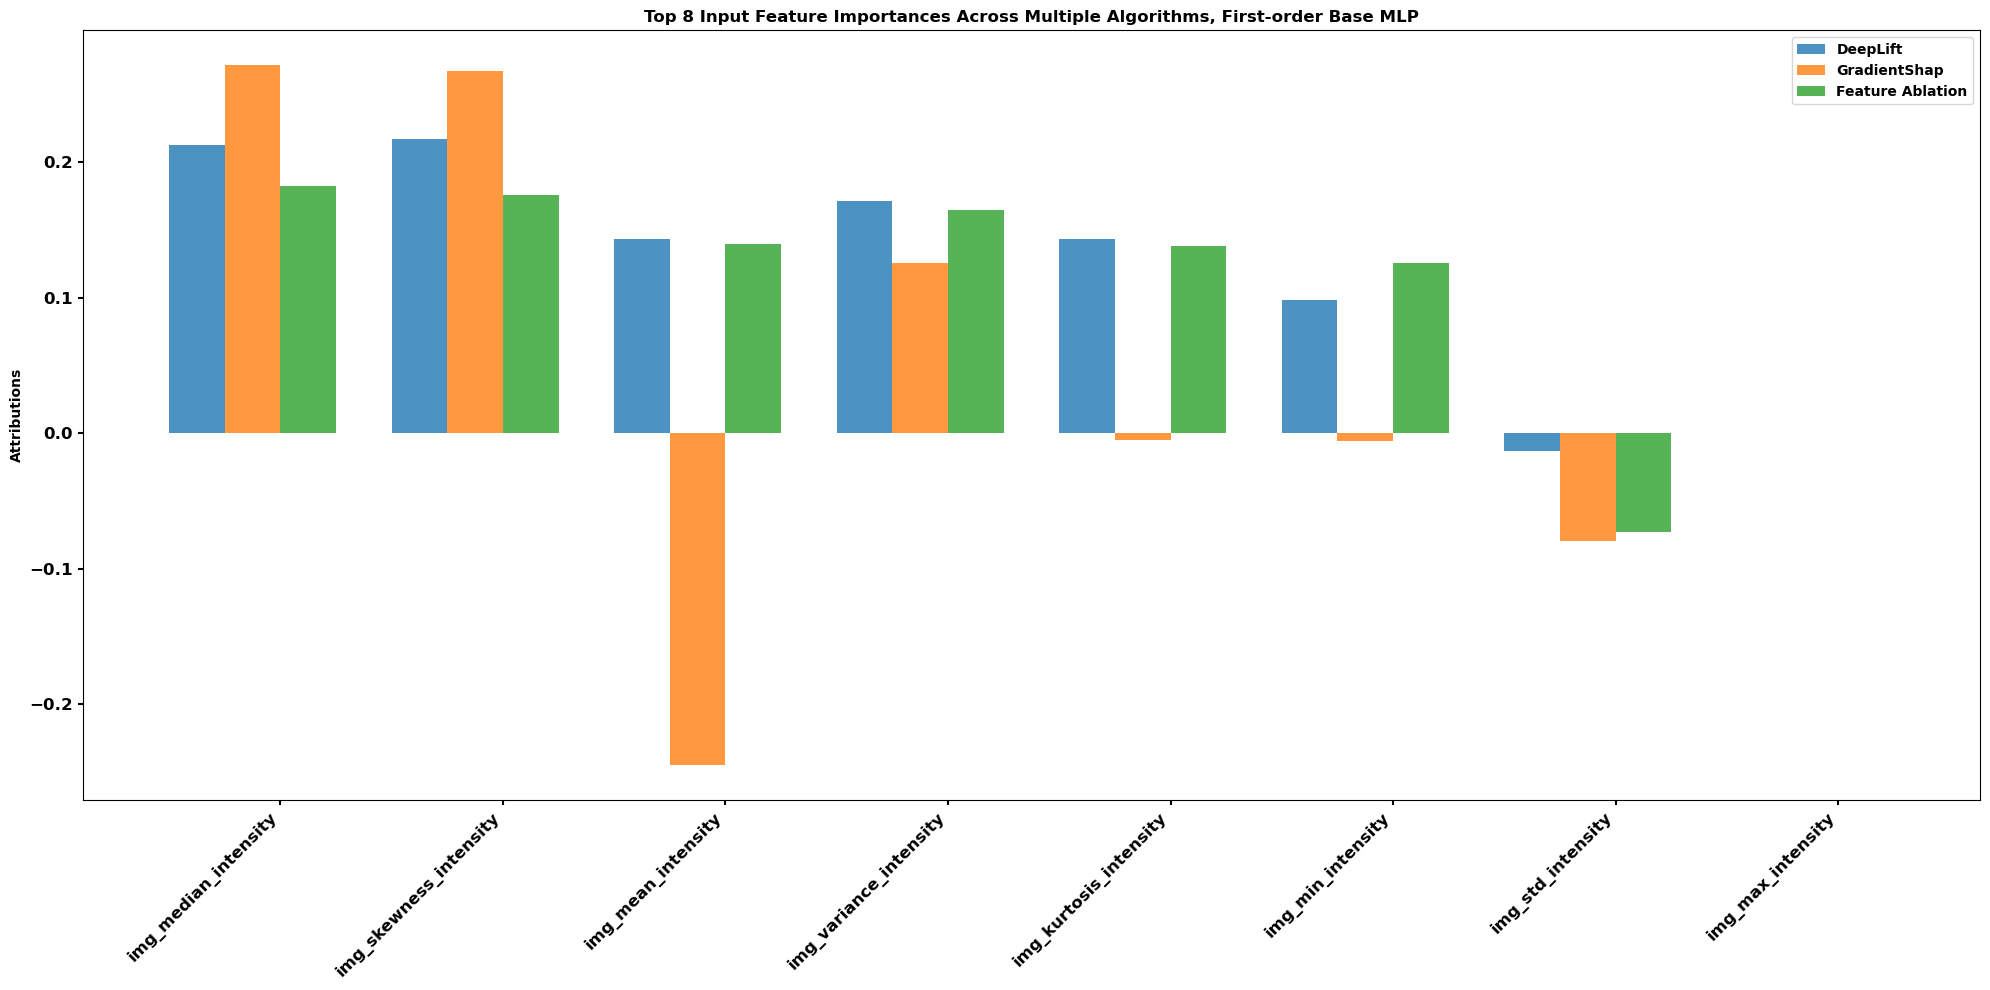

In [12]:
# Plot

# prepare attributions for visualization

x_axis_data = np.arange(X_test.shape[1])
x_axis_data_labels = list(map(lambda idx: feature_names[idx], x_axis_data))


dl_attr_test_sum = dl_attr_test.detach().numpy().sum(0)
dl_attr_test_norm_sum = dl_attr_test_sum / np.linalg.norm(dl_attr_test_sum, ord=1)

gs_attr_test_sum = gs_attr_test.detach().numpy().sum(0)
gs_attr_test_norm_sum = gs_attr_test_sum / np.linalg.norm(gs_attr_test_sum, ord=1)

fa_attr_test_sum = fa_attr_test.detach().numpy().sum(0)
fa_attr_test_norm_sum = fa_attr_test_sum / np.linalg.norm(fa_attr_test_sum, ord=1)


lin_weight = model.model[0].weight[0].detach().numpy()
y_axis_lin_weight = lin_weight / np.linalg.norm(lin_weight, ord=1)


# Step 1: Compute absolute values of attributions
dl_abs     = np.abs(dl_attr_test_norm_sum)
gs_abs     = np.abs(gs_attr_test_norm_sum)
fa_abs     = np.abs(fa_attr_test_norm_sum)

# Step 2: Combine the importance values for an overall ranking.
# Here, we take an average (you could also use sum or another aggregation).
combined_importance = (dl_abs + gs_abs + fa_abs) / 3.0

# Step 3: Get indices for the top N features based on the combined importance.
top_n = 8  # adjust this number to change the number of top features
sorted_indices = np.argsort(-combined_importance)  # negative sign to sort in descending order
top_indices = sorted_indices[:top_n]

# Step 4: Subset the attribution arrays and feature names to only include top features.
top_dl     = dl_attr_test_norm_sum[top_indices]
top_gs     = gs_attr_test_norm_sum[top_indices]
top_fa     = fa_attr_test_norm_sum[top_indices]
top_feature_names = [feature_names[i] for i in top_indices]

# Step 5: Create x-axis data for plotting.
x_axis_data = np.arange(8) # Modify for first-order features
width = 0.25  # defines the width of each bar

# Step 6: Plotting the data using a grouped bar chart.
plt.figure(figsize=(20, 10))
plt.bar(x_axis_data + width,    top_dl,    width, label='DeepLift',         alpha=0.8)
plt.bar(x_axis_data + 2*width,    top_gs,    width, label='GradientShap',     alpha=0.8)
plt.bar(x_axis_data + 3*width,    top_fa,    width, label='Feature Ablation', alpha=0.8)

# Adjust x-axis ticks & labels
plt.xticks(x_axis_data + 2.5*width, top_feature_names, rotation=45, ha='right', fontweight='bold')
plt.ylabel('Attributions', fontweight='bold')
plt.title('Top {} Input Feature Importances Across Multiple Algorithms, First-order Base MLP'.format(top_n), fontweight='bold')
plt.legend(loc='best', prop={'weight':'bold'})

# Set bold font for ticks
plt.tick_params(axis='both', which='major', labelsize=12, labelcolor='black', width=1.5)
for label in plt.gca().get_xticklabels() + plt.gca().get_yticklabels():
    label.set_fontweight('bold')
plt.tight_layout()
# plt.show()
plt.savefig('o1_base_mlp_attribs.svg')

# First-order Tuned MLP

In [13]:
import json

# Path to hyperparameter JSON file
hyperparams_path = '/home/josh/ClotSimNet-Models/hyperparameters/best_params_mlp_o1.json'

with open(hyperparams_path, 'r') as f:
    hyperparams = json.load(f)
    
hyperparameters = hyperparams['hyperparameters']



In [14]:
csv_path = '/home/josh/clotsimnet/data/mlp_data_test.csv'
batch_size = 32
num_workers = 18

# Load dataset
data_module = MLPClotDataseto1(csv_path=csv_path, batch_size=batch_size, num_workers=num_workers)
data_module.setup()

df = pd.read_csv(csv_path)

df = df.dropna(axis=1) # Remove NaN values
# Get feature columns
start_idx = df.columns.get_loc('img_mean_intensity')
end_idx = df.columns.get_loc('img_kurtosis_intensity')

feature_cols = df.columns[start_idx:end_idx+1]

input_data = df[feature_cols].values.astype('float32')
scaler = StandardScaler()
input_data = scaler.fit_transform(input_data)

labels = df['k'].values.astype('float32').reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(input_data, labels, test_size=0.3, random_state=0)

X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).view(-1, 1).float()

X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).view(-1, 1).float()

datasets = torch.utils.data.TensorDataset(X_train, y_train)
train_iter = torch.utils.data.DataLoader(datasets, batch_size=10, shuffle=True)

# Extract names of the features for plotting later
feature_names = df[feature_cols].columns.tolist()

In [15]:
model = MLP.MLP(
        input_size=data_module.X.shape[1],
        hidden_size=hyperparameters['hidden_size'],
        num_layers=hyperparameters['num_layers'],
        learning_rate=hyperparameters['lr'],
        weight_decay=hyperparameters['weight_decay'],
        scheduler_factor=hyperparameters['scheduler_factor'],
        scheduler_patience=hyperparameters['scheduler_patience'],
        scheduler_threshold=hyperparameters['scheduler_threshold']
    )

SAFETENSORS_MODEL_PATH = '/home/josh/ClotSimNet-Models/tuned/mlp_o1/mlp_o1_tuned.safetensors'
load_safetensors(model_obj=model, model_path=SAFETENSORS_MODEL_PATH)

# Set model into evaluation mode
model.eval()

Loading pre-trained model from: /home/josh/ClotSimNet-Models/tuned/mlp_o1/mlp_o1_tuned.safetensors


MLP(
  (model): Sequential(
    (0): Linear(in_features=8, out_features=1480, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1480, out_features=1, bias=True)
  )
  (train_metrics): MetricCollection(
    (MAE): MeanAbsoluteError()
    (MSE): MeanSquaredError()
    (RMSE): MeanSquaredError()
    (r_squared): R2Score(),
    prefix=train_
  )
  (valid_metrics): MetricCollection(
    (MAE): MeanAbsoluteError()
    (MSE): MeanSquaredError()
    (RMSE): MeanSquaredError()
    (r_squared): R2Score(),
    prefix=valid_
  )
  (test_metrics): MetricCollection(
    (MAE): MeanAbsoluteError()
    (MSE): MeanSquaredError()
    (RMSE): MeanSquaredError()
    (r_squared): R2Score(),
    prefix=test_
  )
)

In [16]:
# Run attribution algorithms
dl = DeepLift(model)
gs = GradientShap(model)
fa = FeatureAblation(model)

dl_attr_test = dl.attribute(X_test)
gs_attr_test = gs.attribute(X_test, X_train)
fa_attr_test = fa.attribute(X_test)

/home/josh/anaconda3/envs/clotsimnet/lib/python3.11/site-packages/captum/attr/_core/deep_lift.py:294: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  gradient_mask = apply_gradient_requirements(inputs_tuple)
/home/josh/anaconda3/envs/clotsimnet/lib/python3.11/site-packages/captum/log/dummy_log.py:39: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  return func(*args, **kwargs)


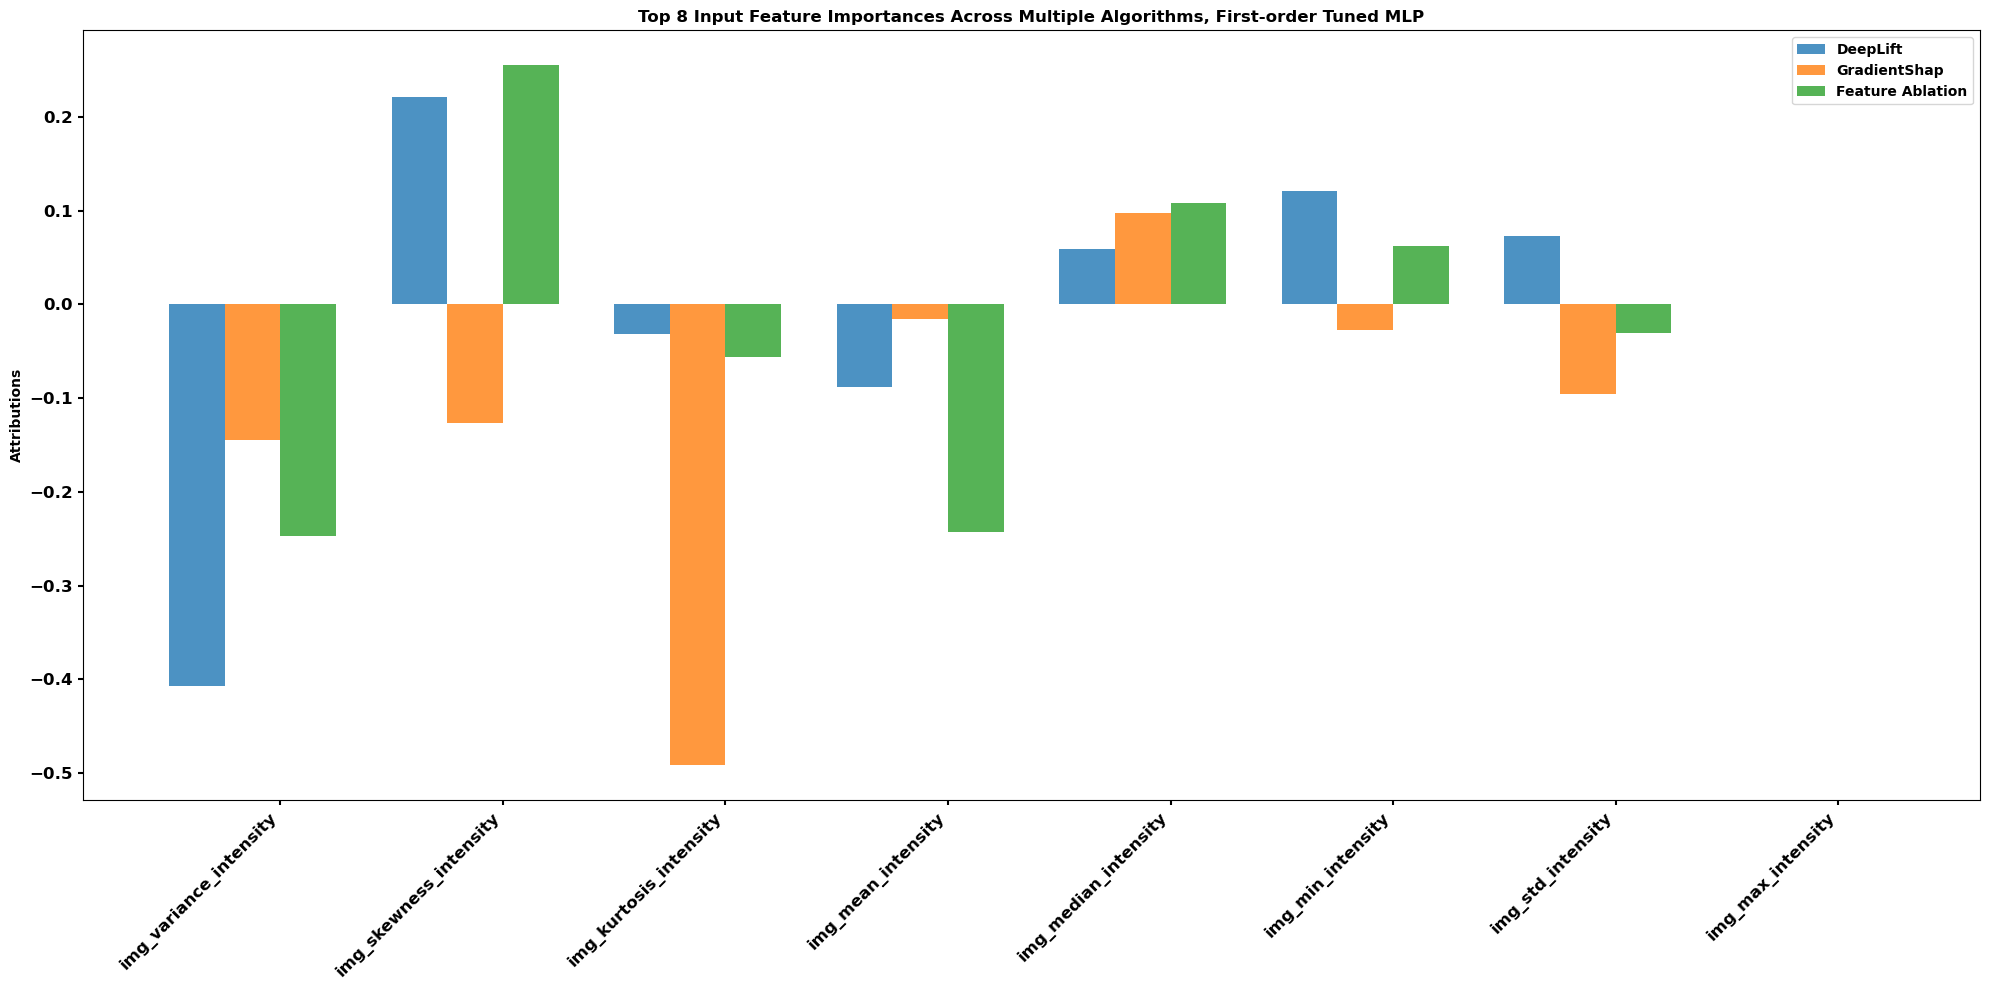

In [17]:
# Plot

# prepare attributions for visualization

x_axis_data = np.arange(X_test.shape[1])
x_axis_data_labels = list(map(lambda idx: feature_names[idx], x_axis_data))


dl_attr_test_sum = dl_attr_test.detach().numpy().sum(0)
dl_attr_test_norm_sum = dl_attr_test_sum / np.linalg.norm(dl_attr_test_sum, ord=1)

gs_attr_test_sum = gs_attr_test.detach().numpy().sum(0)
gs_attr_test_norm_sum = gs_attr_test_sum / np.linalg.norm(gs_attr_test_sum, ord=1)

fa_attr_test_sum = fa_attr_test.detach().numpy().sum(0)
fa_attr_test_norm_sum = fa_attr_test_sum / np.linalg.norm(fa_attr_test_sum, ord=1)


lin_weight = model.model[0].weight[0].detach().numpy()
y_axis_lin_weight = lin_weight / np.linalg.norm(lin_weight, ord=1)


# Step 1: Compute absolute values of attributions
dl_abs     = np.abs(dl_attr_test_norm_sum)
gs_abs     = np.abs(gs_attr_test_norm_sum)
fa_abs     = np.abs(fa_attr_test_norm_sum)

# Step 2: Combine the importance values for an overall ranking.
# Here, we take an average (you could also use sum or another aggregation).
combined_importance = (dl_abs + gs_abs + fa_abs) / 3.0

# Step 3: Get indices for the top N features based on the combined importance.
top_n = 8  # adjust this number to change the number of top features
sorted_indices = np.argsort(-combined_importance)  # negative sign to sort in descending order
top_indices = sorted_indices[:top_n]

# Step 4: Subset the attribution arrays and feature names to only include top features.
top_dl     = dl_attr_test_norm_sum[top_indices]
top_gs     = gs_attr_test_norm_sum[top_indices]
top_fa     = fa_attr_test_norm_sum[top_indices]
top_feature_names = [feature_names[i] for i in top_indices]

# Step 5: Create x-axis data for plotting.
x_axis_data = np.arange(8) # Modify for first-order features
width = 0.25  # defines the width of each bar

# Step 6: Plotting the data using a grouped bar chart.
plt.figure(figsize=(20, 10))
plt.bar(x_axis_data + width,    top_dl,    width, label='DeepLift',         alpha=0.8)
plt.bar(x_axis_data + 2*width,    top_gs,    width, label='GradientShap',     alpha=0.8)
plt.bar(x_axis_data + 3*width,    top_fa,    width, label='Feature Ablation', alpha=0.8)

# Adjust x-axis ticks & labels
plt.xticks(x_axis_data + 2.5*width, top_feature_names, rotation=45, ha='right', fontweight='bold')
plt.ylabel('Attributions', fontweight='bold')
plt.title('Top {} Input Feature Importances Across Multiple Algorithms, First-order Tuned MLP'.format(top_n), fontweight='bold')
plt.legend(loc='best', prop={'weight':'bold'})

# Set bold font for ticks
plt.tick_params(axis='both', which='major', labelsize=12, labelcolor='black', width=1.5)
for label in plt.gca().get_xticklabels() + plt.gca().get_yticklabels():
    label.set_fontweight('bold')
plt.tight_layout()
# plt.show()
plt.savefig('o1_tuned_mlp_attribs.svg')

# Dendrogram Base MLP